In [1]:
import numpy as np

# Backpropagation

## 1. Gradient of loss with respect to weights

In [2]:
inputs = np.array([[1, 2, 3, 2.5],
                   [2, 5, -1, 2],
                   [-1.5, 2.7, 3.3, -0.8]])

dL_dz = np.array([[1, 1, 1],
                  [2, 2, 2],
                  [3, 3, 3]])

# Gradient of loss with respect to weights
dL_dw = np.dot(inputs.T, dL_dz)
print(dL_dw)

[[ 0.5  0.5  0.5]
 [20.1 20.1 20.1]
 [10.9 10.9 10.9]
 [ 4.1  4.1  4.1]]


## 2. Gradient of loss with respect to biases

In [3]:
# Gradient of loss with respect to 
dL_db = np.sum(dL_dz, axis=0, keepdims=True)
print(dL_db)

[[6 6 6]]


## 3. Gradient of loss with respect to inputs

In [4]:
weights = np.array([[0.2, 0.8, -0.5, 1],
                    [0.5, -0.91, 0.26, -0.5],
                    [-0.26, -0.27, 0.17, 0.87]]).T
dL_dX = np.dot(dL_dz, weights.T)
print(dL_dX)

[[ 0.44 -0.38 -0.07  1.37]
 [ 0.88 -0.76 -0.14  2.74]
 [ 1.32 -1.14 -0.21  4.11]]


## 4. Adding the "backward" method in the Layer_Dense class

In [5]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dL_dz):
        self.dL_dw = np.dot(self.inputs.T, dL_dz)
        self.dL_db = np.sum(dL_dz, axis=0, keepdims=True)
        self.dL_dX = np.dot(dL_dz, self.weights.T)

## 5. Now adding the "backward" method in the ReLU Activation and backpropagating through the relu activation function

In [6]:
class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dL_da):
        # Here dL_da is the gradient of L with respect to a. a is the output of the ReLU activation function, a = ReLU(z)
        # We have been given dL_da and we have to find dL_dz (gradient of loss with respect to z), here z is the output of the previous layer which will pass through the activation function
        # So we are basically backpropagating through the relu activation function
        self.dL_dz = dL_da
        self.dL_dz[self.inputs<=0] = 0

## 6. Defining the Categorical Cross Entropy Loss with "backward" method

In [23]:
class Loss_CategoricalCrossEntropy:
    def calculate(self, y_pred, y_true):
        negative_log_likelihoods = self.forward(y_pred, y_true)
        avg_loss = np.mean(negative_log_likelihoods)
        return avg_loss
    
    def forward(self, y_pred, y_true):
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)
        y_true = y_true

        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(len(y_pred_clipped)), y_true]

        if len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)

        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    def backward(self, y_pred,y_true):
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)
        no_of_batches = len(y_pred)
        no_of_labels = len(y_pred[0])
        
        if len(y_true.shape) == 1:
            y_true = np.eye(no_of_labels)[y_true]

        # Calculating gradient
        self.dL_dycap = -y_true / y_pred # Here ycap means the predictions
        
        # Applying the normalization on gradient
        self.normalized_dL_dycap = self.dL_dycap / no_of_batches

y_pred = np.array([[.1, .5, .3, .1],
                   [.2, .1, .4, .3],
                   [.3, .2, .1, .4]])
y_true = np.array([1, 2, 3])
loss_function = Loss_CategoricalCrossEntropy()
loss_function.backward(y_pred, y_true)
print(loss_function.dL_dycap)
print(loss_function.normalized_dL_dycap)

[[-0.  -2.  -0.  -0. ]
 [-0.  -0.  -2.5 -0. ]
 [-0.  -0.  -0.  -2.5]]
[[-0.         -0.66666667 -0.         -0.        ]
 [-0.         -0.         -0.83333333 -0.        ]
 [-0.         -0.         -0.         -0.83333333]]


## 7. Softmax classifier - combined Softmax activation with categorical cross entropy loss function for faster "backward" step

In [43]:
class Activation_Softmax:
    def forward(self, final_layer_outputs):
        exp_values = np.exp(final_layer_outputs - np.max(final_layer_outputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities

class Activation_Softmax_Loss_CategoricalCrossEntropy:
    def __init__(self):
        self.activation_softmax = Activation_Softmax()
        self.loss_function = Loss_CategoricalCrossEntropy()
    
    def forward(self, final_layer_outputs, y_true):
        # Calculating softmax activation outputs
        self.activation_softmax.forward(final_layer_outputs)
        self.output = self.activation_softmax.output

        # Calculating loss
        self.loss = self.loss_function.calculate(self.output, y_true)
        return self.loss

    def backward(self, softmax_outputs, y_true):
        no_of_batches = len(softmax_outputs)

        # Converting the y_true to discrete vector if it is in one hot encoding
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        self.dL_dz = softmax_outputs.copy()
        # Calculating gradient
        self.dL_dz[range(no_of_batches), y_true] -= 1

        # Applying normalization
        self.dL_dz = self.dL_dz / no_of_batches

softmax_outputs = np.array([[.7, .1, .2],
                            [.1, .5, .4],
                            [.02, .9, .08]])
class_targets = np.array([0, 1, 1])
softmax_loss = Activation_Softmax_Loss_CategoricalCrossEntropy()
softmax_loss.backward(softmax_outputs, class_targets)
normalized_dL_dz = softmax_loss.dL_dz
print("Gradients: Combined loss and softmax activation ->")
print(normalized_dL_dz)

Gradients: Combined loss and softmax activation ->
[[-0.1         0.03333333  0.06666667]
 [ 0.03333333 -0.16666667  0.13333333]
 [ 0.00666667 -0.03333333  0.02666667]]


# Coding the forward and backward pass

## 1. Load the spiral dataset

[[-0.          0.        ]
 [-0.00816894  0.00594128]
 [ 0.01361373  0.01492608]
 [ 0.00659183  0.02957738]
 [-0.00860565  0.03947695]]


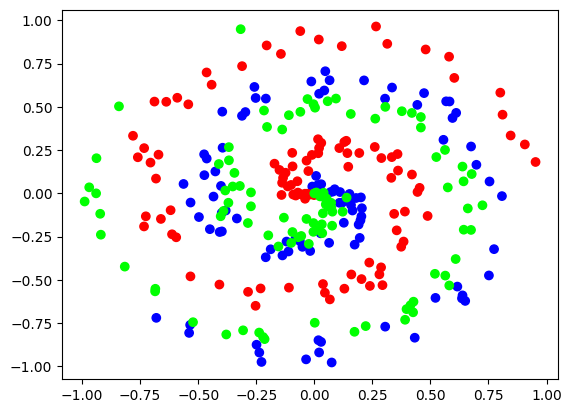

In [44]:
from nnfs.datasets import spiral_data
import matplotlib.pyplot as plt

X, y = spiral_data(samples=100, classes=3)
print(X[:5])
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="brg")
plt.show()

## 2. Forward and Backward pass 

In [67]:
# Defining learning rate
learning_rate = 0.001

# Defining the classes
dense_layer1 = Layer_Dense(2, 3)
activation_relu = Activation_ReLU()
dense_layer2 = Layer_Dense(3, 3)
loss_activation_softmax = Activation_Softmax_Loss_CategoricalCrossEntropy()

# Forward pass
dense_layer1.forward(X)
activation_relu.forward(dense_layer1.output)
dense_layer2.forward(activation_relu.output)
loss_activation_softmax.forward(dense_layer2.output, y)
print("Softmax Outputs ->\n", loss_activation_softmax.output[:3])

# Printing performance matrices
print("Loss:", loss_activation_softmax.loss)
predictions = np.argmax(loss_activation_softmax.output, axis=1)
accuracy = np.mean(predictions==y)
print("Accuracy:", accuracy)

# Backward pass
loss_activation_softmax.backward(loss_activation_softmax.output, y)
dense_layer2.backward(loss_activation_softmax.dL_dz)
activation_relu.backward(dense_layer2.dL_dX)
dense_layer1.backward(activation_relu.dL_dz)

# Gradients of weights and biases
print(dense_layer1.dL_dw)
print(dense_layer1.dL_db)
print(dense_layer2.dL_dw)
print(dense_layer2.dL_db)

Softmax Outputs ->
 [[0.33333333 0.33333333 0.33333333]
 [0.33333297 0.33333331 0.33333372]
 [0.33333335 0.333334   0.33333265]]
Loss: 1.09860959945827
Accuracy: 0.3233333333333333
[[-1.73465174e-05  1.97900220e-04  4.05351700e-05]
 [-3.29925951e-04  1.02982620e-04 -1.98345283e-05]]
[[-3.93254471e-05 -2.83456426e-05 -3.71793010e-05]]
[[-2.88266097e-05 -3.16976018e-05  6.05242116e-05]
 [ 1.07488480e-04 -8.46207558e-05 -2.28677244e-05]
 [ 1.29585887e-05  1.00901195e-04 -1.13859783e-04]]
[[-6.51059056e-06  5.97300224e-06  5.37588319e-07]]


## 3. Applying gradient decent

In [68]:
dense_layer1.weights -= learning_rate*dense_layer1.dL_dw
dense_layer1.biases -= learning_rate*dense_layer1.dL_db
dense_layer2.weights -= learning_rate*dense_layer2.dL_dw
dense_layer2.biases -= learning_rate*dense_layer2.dL_db

## 4. Finding the loss and accuracy after gradient decent

In [70]:
# Forward pass
dense_layer1.forward(X)
activation_relu.forward(dense_layer1.output)
dense_layer2.forward(activation_relu.output)
loss_activation_softmax.forward(dense_layer2.output, y)
print("Softmax Outputs ->\n", loss_activation_softmax.output[:3])

# Printing performance matrices
print("Loss:", loss_activation_softmax.loss)
predictions = np.argmax(loss_activation_softmax.output, axis=1)
accuracy = np.mean(predictions==y)
print("Accuracy:", accuracy)

Softmax Outputs ->
 [[0.33333334 0.33333333 0.33333333]
 [0.33333297 0.33333331 0.33333372]
 [0.33333335 0.333334   0.33333265]]
Loss: 1.098609599245451
Accuracy: 0.3233333333333333
